In [1]:
'''
Zé Fonseca

24/02/16

MCMC for general cosmological datasets.
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
#from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
import sys

%matplotlib inline

## Data info

* N_SNeIa=10, gaussian distribution ~${\cal N}(0.5,0.1)$;
* errors: $\sigma_\mu=0.01$, $\sigma_z=0.01(1+z)$;


In [2]:
#cosmological functions
#general functions

def invH(z,OM,w):
    return (OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))**(-.5)

c=2.99792e5

def mu(z,OM,H0,w):
    if type(z)==float or type(z)==int:
        return 5*np.log10((1+z)/H0*c*quad(invH,0,z,args=(OM,w))[0])+25
    else:
        dl=[]
        for i in range(len(z)):
            dl.append(quad(invH,0,z[i],args=(OM,w))[0])
        return 5*np.log10(np.array(dl)*(1+z)*c/H0)+25

#class fake data with all the cases.

class fkd:
    def __init__(self,name,filename,OM=0.31,H0=67.74,w=-1,sig_mu=0.01,wrong_data=True,sig_z_per=0.01,zb=0.5,sp=0.1):
        #parameters used
        self.OM=OM
        self.H0=H0
        self.w=w
        self.dataset=name
        
        dados=np.loadtxt(filename)
        self.z=dados[:,0]
        self.mu_o=dados[:,1]
        self.sig_mu=sig_mu
        if wrong_data==True:
            self.z_real=dados[:,2]
        self.sig_z=sig_z_per*(1+self.z)
        self.zb=zb
        self.sp=sp
        

In [3]:
#initiate data
fd1=fkd('cosmoSNe_1','../general_datasets/data_cosmoSNe_1.txt')
fd2=fkd('cosmoSNe_2','../general_datasets/data_cosmoSNe_2.txt')
fd3=fkd('cosmoSNe_3','../general_datasets/data_cosmoSNe_3.txt')
fd4=fkd('cosmoSNe_4','../general_datasets/data_cosmoSNe_4.txt')
fd5=fkd('cosmoSNe_5','../general_datasets/data_cosmoSNe_5.txt')


# Part 2

## MCMC to data with errors in z

Notes: when adding errors in MCMC we need 3 different error adding. Case 3 does not have mu errors increased in quadrature. 

The likelihood to use is
\begin{equation}
\log L_i=-\frac{1}{2}\left(\frac{\mu_{\rm Obs,i}-\mu(z_{\rm Obs,i},\Omega_m,H_0,w)}{\sigma_\mu}\right)^2
\end{equation}
with
\begin{equation}
\log L=\sum_i \log L_i
\end{equation}


In [4]:
# Functions

#MCMC priors
def prior_om(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0
    
def prior_w(x):
    if x>=-6 and x<=4:
        return 1
    else:
        return 0
    
def prior_H0(x):
    if x>=10 and x<=200:
        return 1
    else:
        return 0
    
def chi2(mu_o,mu_t,sigma2):
    return (mu_o-mu_t)**2/sigma2

def log_like_fixsig(data,om,H0,w):
    mu_t=mu(data.z,om,H0,w)
    return -chi2(data.mu_o,mu_t,data.sig_mu**2)/2


In [51]:
def MCMC_SNe(N,data,loglike_func=log_like_fixsig):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    log_like=np.zeros(N)
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    log_like[0]=sum(loglike_func(data,o_m[0],H0[0],w[0]))
    
    #dummy var for acceptance rate
    accept=1
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1]=log_like[i]
            continue
        else:
            #compute new log_like
            log_like[i+1]=sum(loglike_func(data,o_m[i+1],H0[i+1],w[i+1]))
            #if priors not flat they need to be included after the exp. for now flat prior
            r=sp.exp(log_like[i+1]-log_like[i])
            #accept or not
            teste=np.random.rand()
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1]=log_like[i]
                continue
                
        #really cool piece of code from Ethan but breaks for no reason ramdomly???
        accept+=1
        if i%1000==0:
            inc100 = np.int64(i/(N)*100)
            inc50 = np.int64(i/(N)*50)
            sys.stdout.write('\r')
            sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
            sys.stdout.flush()
    
    acceptr=accept/N*100
    return o_m,w,H0,log_like,acceptr

In [50]:
60100%1000

100

## Make plots

In [145]:
def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

datas={'0':fd1,'1':fd2,'2':fd3,'3':fd4,'4':fd5}
nb=20
cor=['k','b','r','g','m']

def plot_contour_hist_1(data1,burn_tail=500,thining=1,nb=10,loglike='normal'):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    
    if loglike=='normal':
        om=data1.nl_o_m[burn_tail::thining]
        w=data1.nl_w[burn_tail::thining]
        H0=data1.nl_H0[burn_tail::thining]
    if loglike=='am_fixhyper':
        om=data1.anlm_o_m[burn_tail::thining]
        w=data1.anlm_w[burn_tail::thining]
        H0=data1.anlm_H0[burn_tail::thining]
    if loglike=='num_marg':
        om=data1.nmarg_o_m[burn_tail::thining]
        w=data1.nmarg_w[burn_tail::thining]
        H0=data1.nmarg_H0[burn_tail::thining]
    if loglike=='am_fithyper':
        om=data1.fithyper_o_m[burn_tail::thining]
        w=data1.fithyper_w[burn_tail::thining]
        H0=data1.fithyper_H0[burn_tail::thining]
    if loglike=='num_marg_fithyper':
        om=data1.nmarg_fithyper_o_m[burn_tail::thining]
        w=data1.nmarg_fithyper_w[burn_tail::thining]
        H0=data1.nmarg_fithyper_H0[burn_tail::thining]    
    
    Hist_mcmc, omedges,wedges = np.histogram2d(om,w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Neff=len(om)
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    #plt.plot(om_max,w_max,'rx',ms=10)
    
    bins_om=[round(x*0.025,3) for x in range(0,40)]
    bins_w=[round(x*0.05-6,3) for x in range(0,140)]
    bins_H=[x*0.25+50 for x in range(0,500)]

        
    om_min=np.amin(om)
    om_max=np.amax(om)
    
    w_min=np.amin(w)
    w_max=np.amax(w)
    
    H0_min=np.amin(H0)
    H0_max=np.amax(H0)
               
    axarr[0,0].hist(om,color='r',bins=bins_om,alpha=0.15)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    axarr[1,0].contour(om_c,w_c, Hist_mcmc.T,levels=[N95,N68,Nmax])
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(H0,bins=bins_H,color='r',alpha=0.15)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    
    axarr[1,1].hist(w,bins=bins_w,color='r',alpha=0.15,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    axarr[1,1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.show()
    
def plot_conv_mcmc(data1,burn_tail=0,thining=1,loglike='normal'):
    
    f, axarr = plt.subplots(3,1,figsize=(8,12))
    
    if loglike=='normal':
        om=data1.nl_o_m[burn_tail::thining]
        w=data1.nl_w[burn_tail::thining]
        H0=data1.nl_H0[burn_tail::thining]
    if loglike=='unbias':
        om=data1.anlm_chain_o_m[burn_tail::thining]
        w=data1.anlm_chain_w[burn_tail::thining]
        H0=data1.anlm_chain_H0[burn_tail::thining]
    if loglike=='real_z':
        om=data1.rz_chain_o_m[burn_tail::thining]
        w=data1.rz_chain_w[burn_tail::thining]
        H0=data1.rz_chain_H0[burn_tail::thining]
    if loglike=='num_marg':
        om=data1.nmarg_chain_o_m[burn_tail::thining]
        w=data1.nmarg_chain_w[burn_tail::thining]
        H0=data1.nmarg_chain_H0[burn_tail::thining]
        
    axarr[0].plot(om)
    axarr[0].set_ylim([np.amin(om),np.amax(om)])
    axarr[0].set_ylabel(r'$\Omega_M$')
    
    axarr[1].plot(w)
    axarr[1].set_ylim([np.amin(w),np.amax(w)])
    axarr[1].set_ylabel(r'$w$')
    
    axarr[2].plot(H0)
    axarr[2].set_ylim([np.amin(H0),np.amax(H0)])
    axarr[2].set_ylabel(r'$H_0$')
    
    plt.setp(axarr[0].get_xticklabels(), visible=False)
    plt.setp(axarr[1].get_xticklabels(), visible=False)
    
    plt.show()

# Run for dataset with normal likelihood

In [12]:
Nsteps=100000

In [15]:
fd1.nl_o_m,fd1.nl_w,fd1.nl_H0,fd1.nl_log_like,fd1.nl_acceptr=MCMC_SNe(Nsteps,fd1,log_like_fixsig)
print('\n',fd1.nl_acceptr)


[################################################# ]99%
 2.453


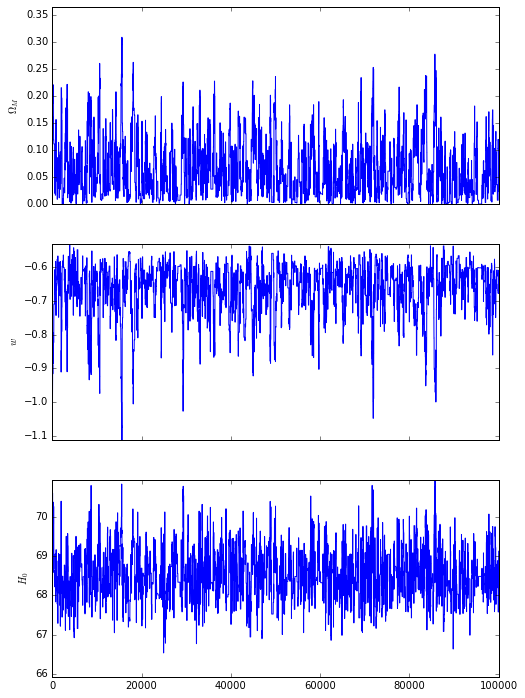

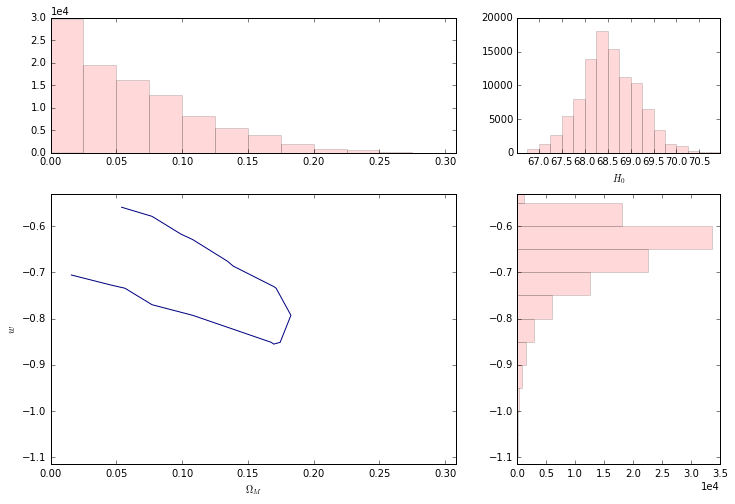

In [16]:
plot_conv_mcmc(fd1)
plot_contour_hist_1(fd1)


[################################################# ]99%
 2.645


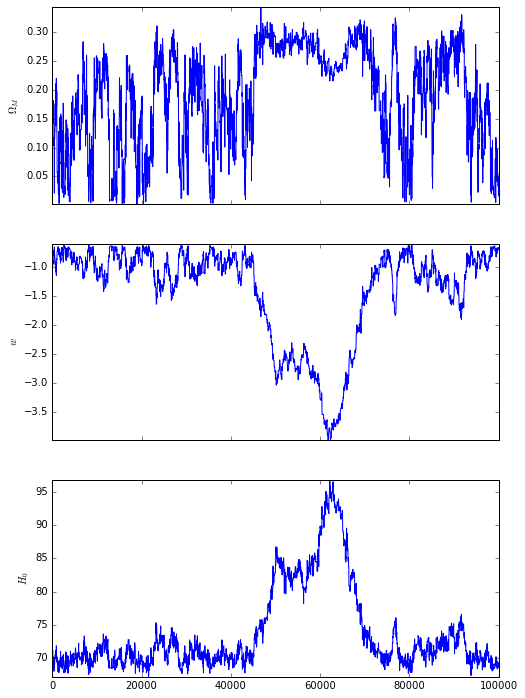

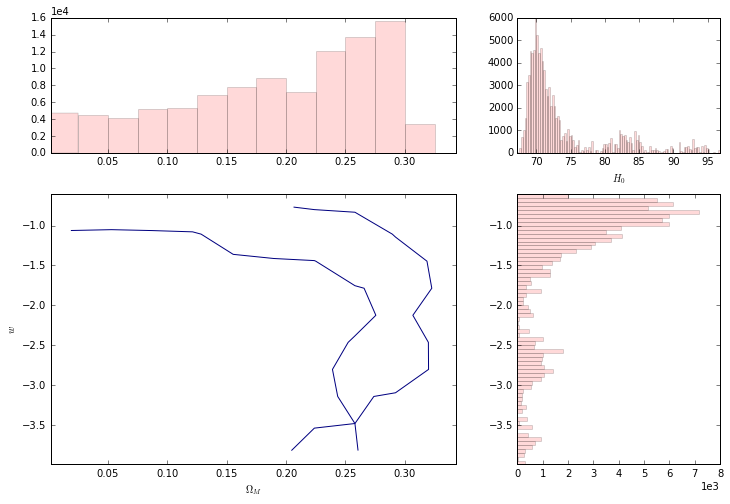

In [17]:
fd2.nl_o_m,fd2.nl_w,fd2.nl_H0,fd2.nl_log_like,fd2.nl_acceptr=MCMC_SNe(Nsteps,fd2,log_like_fixsig)
print('\n',fd2.nl_acceptr)
plot_conv_mcmc(fd2)
plot_contour_hist_1(fd2)
plt.show()

[################################################# ]99%
 5.314


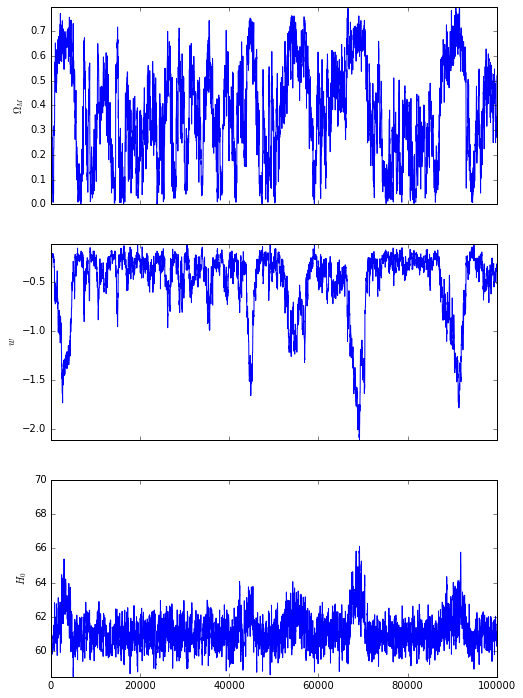

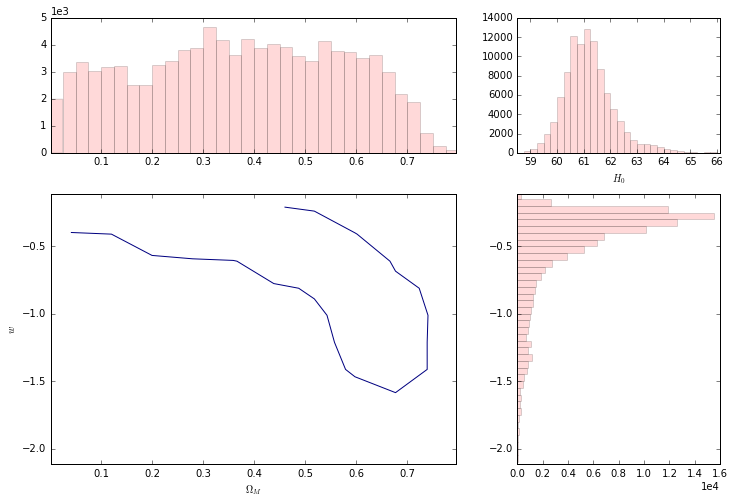

In [19]:
fd3.nl_o_m,fd3.nl_w,fd3.nl_H0,fd3.nl_log_like,fd3.nl_acceptr=MCMC_SNe(Nsteps,fd3,log_like_fixsig)
print('\n',fd3.nl_acceptr)
plot_conv_mcmc(fd3)
plot_contour_hist_1(fd3)
plt.show()

[                                                  ]0%

/Users/Ze/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:32: RuntimeWarning: overflow encountered in exp


[################################################# ]99%
 2.767


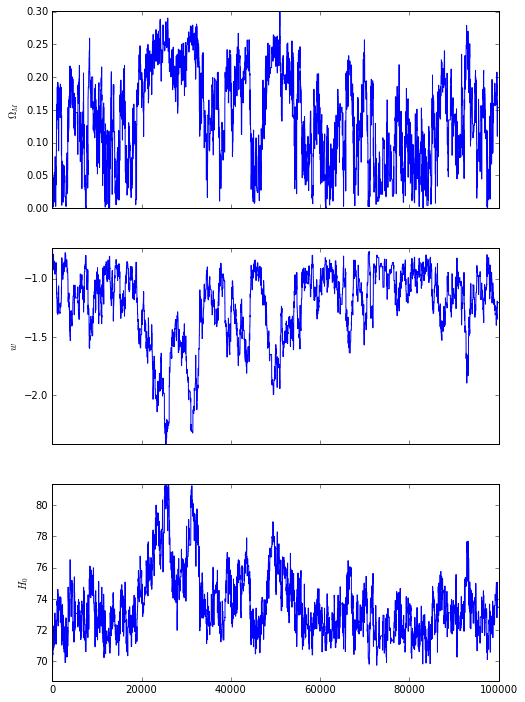

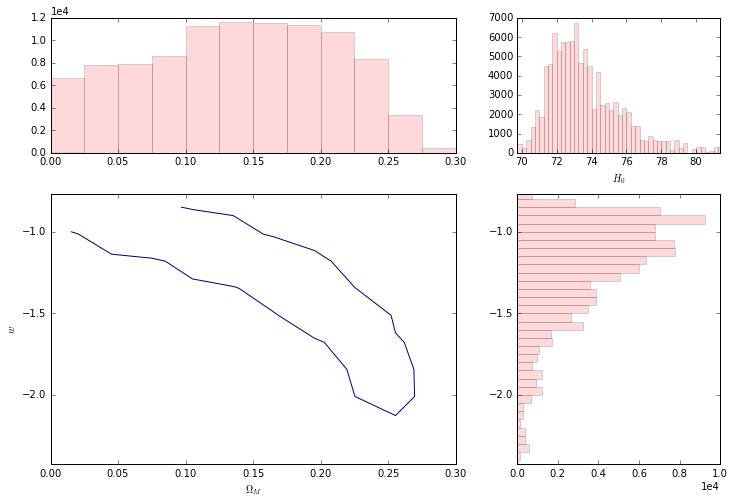

In [20]:
fd4.nl_o_m,fd4.nl_w,fd4.nl_H0,fd4.nl_log_like,fd4.nl_acceptr=MCMC_SNe(Nsteps,fd4,log_like_fixsig)
print('\n',fd4.nl_acceptr)
plot_conv_mcmc(fd4)
plot_contour_hist_1(fd4)
plt.show()

[################################################# ]99%
 2.146


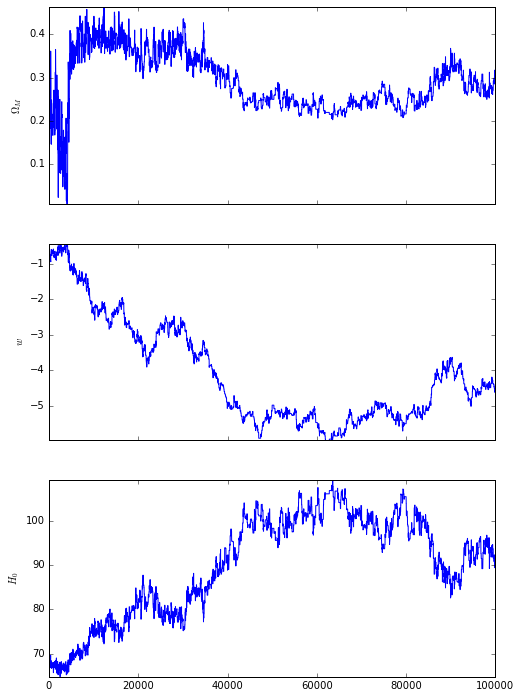

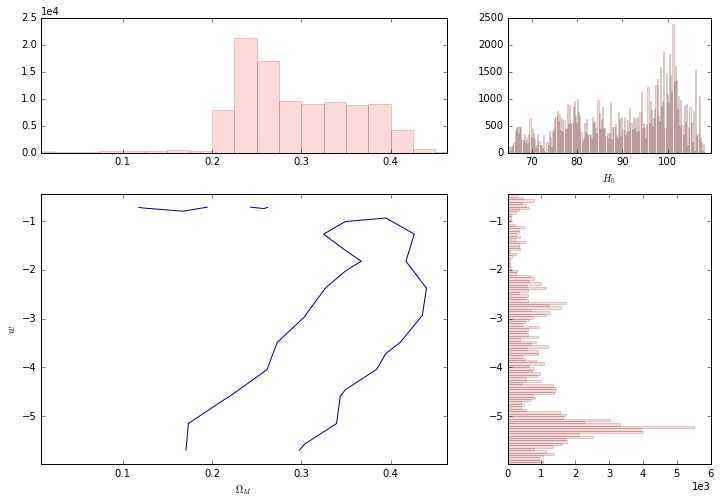

In [21]:
fd5.nl_o_m,fd5.nl_w,fd5.nl_H0,fd5.nl_log_like,fd5.nl_acceptr=MCMC_SNe(Nsteps,fd5,log_like_fixsig)
print('\n',fd5.nl_acceptr)
plot_conv_mcmc(fd5)
plot_contour_hist_1(fd5)
plt.show()

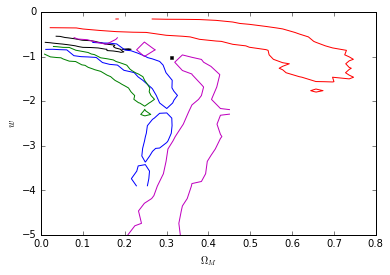

In [23]:

for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].nl_o_m,datas[str(i)].nl_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains.png')
plt.show()

In [24]:
def save_mcmc(data):
    np.savetxt('../general_datasets/chains_'+data.dataset+'.txt',np.c_[data.nl_o_m,data.nl_w,data.nl_H0,
                                                                       data.nl_log_like],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3f'],header='\n'.join(["acceptance rate %.2f" %data.nl_acceptr,\
                                                                           "Om   w   H0   log_like"]))

In [25]:
for i in range(5):
    save_mcmc(datas[str(i)])

## Analytical marginalization using taylor expression, gaussian prior known,

The first thing to consider is that we make a taylor expansion of $\mu(z)$ around some measured redshift $z_i$. Then
\begin{equation}
\mu(z,\theta)=\mu(z_i,\theta)+\frac{\partial \mu(z,\theta)}{\partial z}\bigg|_{z=z_i}(z-z_i)+\ldots
\end{equation}
Then seting $m=\frac{\partial \mu(z,\theta)}{\partial z}\bigg|_{z=z_i}$ 
and $\tilde \mu_{0,i}=\mu_{\rm Obs,i}-\mu(z_i,\theta)+z_i m$ the likelihood is 
\begin{equation}
\log L_i=-\frac{1}{2C}\left[\sigma_\mu^2(z_{\rm Obs,i}-\bar z)^2 +\sigma_p^2(\mu_{\rm Obs,i}-\mu(z_{\rm Obs,i},\theta))^2 +\sigma_z^2 (\tilde\mu_{0,i}-m\bar z)^2\right]-\frac{C}{2} + constants
\end{equation}
where
\begin{equation}
C=\sigma_\mu^2(\sigma_p^2+\sigma_z^2) + m^2\sigma_p^2\sigma_z^2
\end{equation}

And we fit for $\vartheta=\Omega_m,H_0,w$ assuming $\bar z=0.5$ and $\sigma_p=0.1$.



In [37]:
# Highly inneficient coding but I wanna keep track of everuthing

def dmudz(z,mu,OM,H0,w):
    return 5/np.log(10)*(1/(1+z)+(1+z)*c*invH(z,OM,w)/H0*10**(5-mu/5))


def log_like_analmarg(data,om,H0,w):
    m=dmudz(data.z,mu(data.z,om,H0,w),om,H0,w)
    mt=mu(data.z,om,H0,w)
    red_mu_o=data.mu_o-mt+data.z*m
    Cov=data.sig_mu**2*(data.sp**2+data.sig_z**2)+(m*data.sp*data.sig_z)**2
    
    return -0.5*((data.sig_mu*(data.z-data.zb))**2+(data.sp*(data.mu_o-mt))**2+\
                 (data.sig_z*(red_mu_o-m*data.zb))**2)/Cov-0.5*Cov

In [39]:
fd1.anlm_o_m,fd1.anlm_w,fd1.anlm_H0,fd1.anlm_log_like,fd1.anlm_acceptr=MCMC_SNe(Nsteps,fd1,loglike_func=log_like_analmarg)

[################################################# ]99%

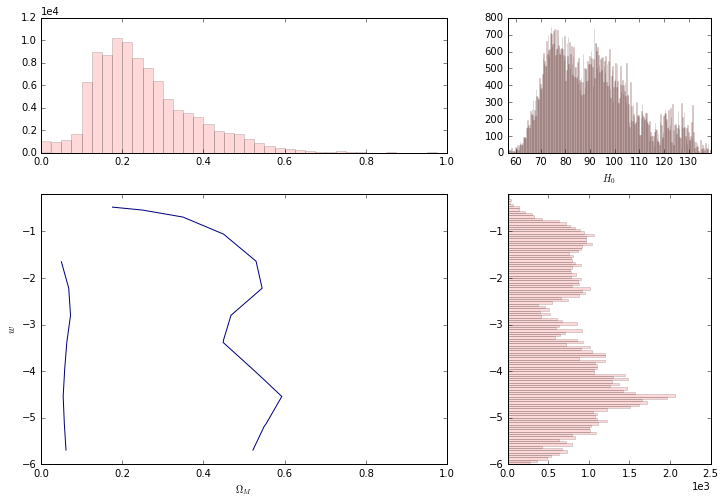

In [40]:
plot_contour_hist_1(fd1,loglike='am_fixhyper')

In [42]:
fd1.anlm_acceptr

19.634999999999998

In [52]:
fd2.anlm_o_m,fd2.anlm_w,fd2.anlm_H0,fd2.anlm_log_like,fd2.anlm_acceptr=MCMC_SNe(Nsteps,fd2,loglike_func=log_like_analmarg)
print('\n',fd2.anlm_acceptr)
fd3.anlm_o_m,fd3.anlm_w,fd3.anlm_H0,fd3.anlm_log_like,fd3.anlm_acceptr=MCMC_SNe(Nsteps,fd3,loglike_func=log_like_analmarg)
print('\n',fd3.anlm_acceptr)
fd4.anlm_o_m,fd4.anlm_w,fd4.anlm_H0,fd4.anlm_log_like,fd4.anlm_acceptr=MCMC_SNe(Nsteps,fd4,loglike_func=log_like_analmarg)
print('\n',fd4.anlm_acceptr)
fd5.anlm_o_m,fd5.anlm_w,fd5.anlm_H0,fd5.anlm_log_like,fd5.anlm_acceptr=MCMC_SNe(Nsteps,fd5,loglike_func=log_like_analmarg)
print('\n',fd5.anlm_acceptr)

[########################################          ]80%
 14.628
[################################################  ]97%
 24.731
[################################################  ]97%
 24.354
[###############################################   ]95%
 26.68


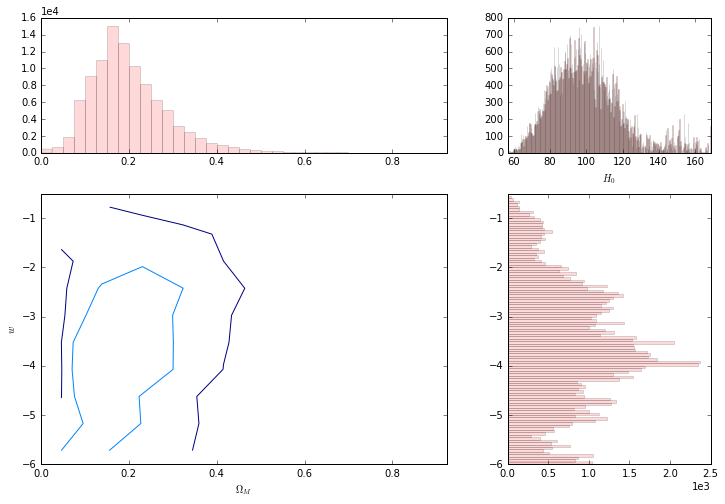

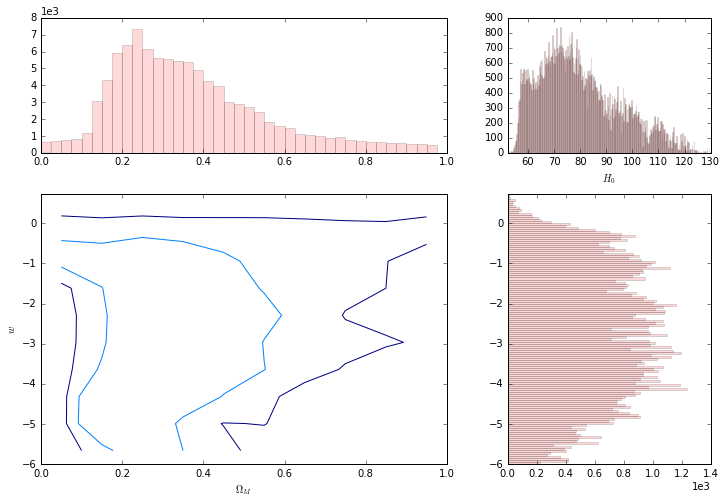

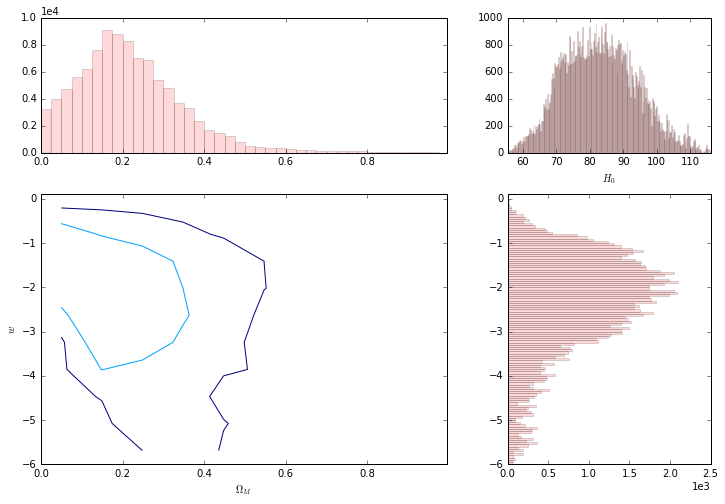

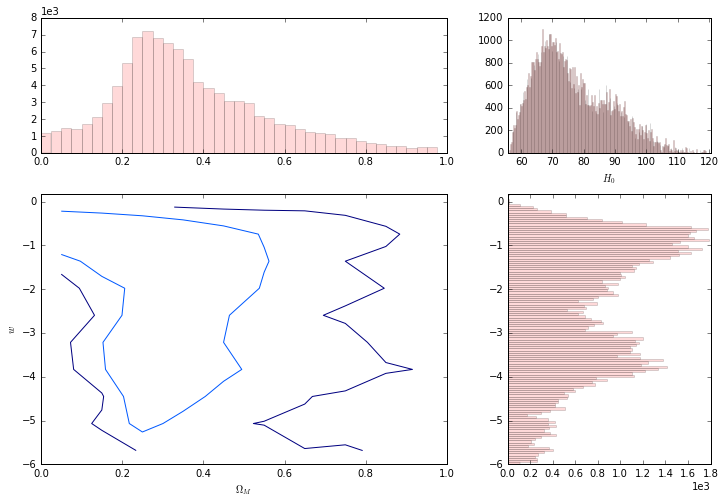

In [149]:
plot_contour_hist_1(fd2,loglike='am_fixhyper')
plot_contour_hist_1(fd3,loglike='am_fixhyper')
plot_contour_hist_1(fd4,loglike='am_fixhyper')
plot_contour_hist_1(fd5,loglike='am_fixhyper')

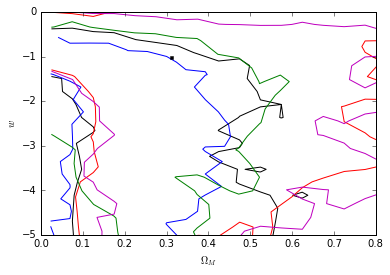

In [55]:
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].anlm_o_m,datas[str(i)].anlm_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains_analmarg.png')
plt.show()

## Analytical marginalization using taylor expression but also fitting for gaussian hyperparameters

The likelihood is equal to the one used before but know we also fit for the hyperparameters, i.e., 
\begin{equation}
\log L_i=-\frac{1}{2C}\left[\sigma_\mu^2(z_{\rm Obs,i}-\bar z)^2 +\sigma_p^2(\mu_{\rm Obs,i}-\mu(z_{\rm Obs,i},\theta))^2 +\sigma_z^2 (\tilde\mu_{0,i}-m\bar z)^2\right]-\frac{C}{2} + constants
\end{equation}
where
\begin{equation}
C=\sigma_\mu^2(\sigma_p^2+\sigma_z^2) + m^2\sigma_p^2\sigma_z^2
\end{equation}

And we fit for $\vartheta=\Omega_m,H_0,w,\bar z,\sigma_p$.


In [65]:
def log_like_fithyper_analmarg(data,om,H0,w,zb,sp):
    mt=mu(data.z,om,H0,w)
    m=dmudz(data.z,mt,om,H0,w)
    red_mu_o=data.mu_o-mt+data.z*m
    Cov=data.sig_mu**2*(sp**2+data.sig_z**2)+(m*sp*data.sig_z)**2
    
    return -0.5*((data.sig_mu*(data.z-zb))**2+(sp*(data.mu_o-mt))**2+\
                 (data.sig_z*(red_mu_o-m*zb))**2)/Cov-0.5*Cov

def prior_zb(x):
    if x>=0 and x<1:
        return 1
    else:
        return 0
    
def prior_sp(x):
    if x>=0.001 and x<1:
        return 1
    else:
        return 0

def MCMC_SNe_fithyper(N,data):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    zb=np.zeros(N)
    sp=np.zeros(N)
    log_like=np.zeros(N)
    

    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    zb[0]=0.4
    sp[0]=0.2
    log_like[0]=sum(log_like_fithyper_analmarg(data,o_m[0],H0[0],w[0],zb[0],sp[0]))
    
    #dummy var for acceptance rate
    accept=1
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        zb[i+1]=zb[i]+np.random.randn()*0.01
        sp[i+1]=sp[i]+np.random.randn()*0.01
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0 or prior_zb(zb[i+1])==0 or prior_sp(sp[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            zb[i+1]=zb[i]
            sp[i+1]=sp[i]
            
            log_like[i+1]=log_like[i]
            continue
        else:
            #compute new log_like
            log_like[i+1]=sum(log_like_fithyper_analmarg(data,o_m[i+1],H0[i+1],w[i+1],zb[i+1],sp[i+1]))
            #if priors not flat they need to be included after the exp. for now flat prior
            r=np.exp(log_like[i+1]-log_like[i])
            #accept or not
            teste=np.random.rand()
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                zb[i+1]=zb[i]
                sp[i+1]=sp[i]
                log_like[i+1]=log_like[i]
                
                continue
        
        accept+=1
        if i%1000==0:
            inc100 = np.int64(i/(N)*100)
            inc50 = np.int64(i/(N)*50)
            sys.stdout.write('\r')
            sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
            sys.stdout.flush()
    
    acceptr=accept/N*100
    data.fithyper_acceptr=acceptr
    data.fithyper_o_m=o_m
    data.fithyper_w=w
    data.fithyper_H0=H0
    data.fithyper_zb=zb
    data.fithyper_sp=sp
    data.fithyper_log_like=log_like
    

In [66]:
MCMC_SNe_fithyper(Nsteps,fd1)
print('\n',fd1.fithyper_acceptr)

[################################################# ]99%
 26.433


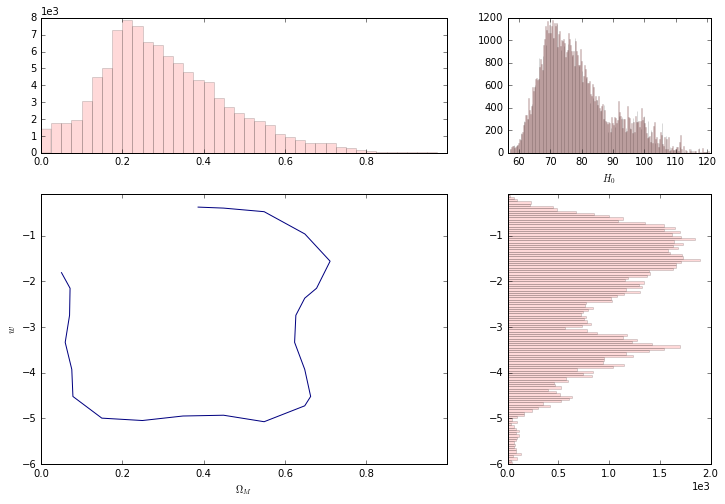

In [67]:
plot_contour_hist_1(fd1,loglike='am_fithyper')

In [68]:
MCMC_SNe_fithyper(Nsteps,fd2)
MCMC_SNe_fithyper(Nsteps,fd3)

[###############################################   ]95%

In [69]:
MCMC_SNe_fithyper(Nsteps,fd4)
MCMC_SNe_fithyper(Nsteps,fd5)

[################################################  ]96%

In [70]:
print('\n',fd2.fithyper_acceptr)
print('\n',fd3.fithyper_acceptr)
print('\n',fd4.fithyper_acceptr)
print('\n',fd5.fithyper_acceptr)


 16.747999999999998

 28.116999999999997

 21.278

 25.66


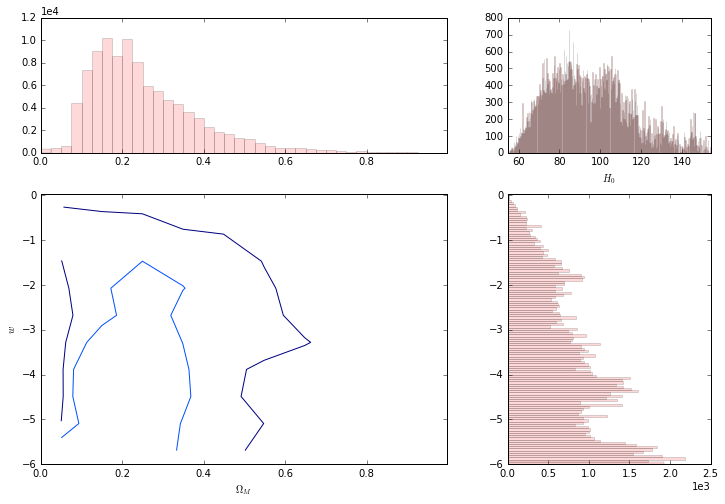

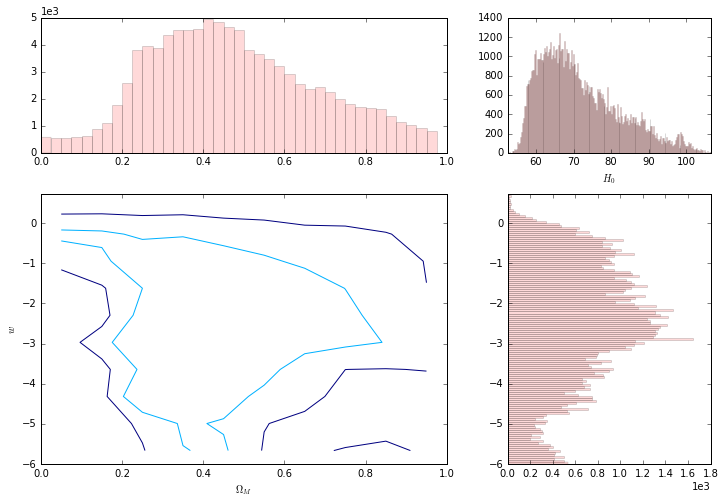

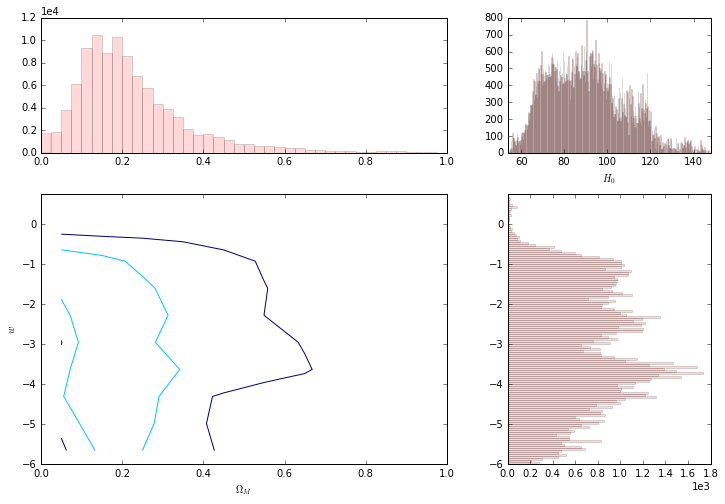

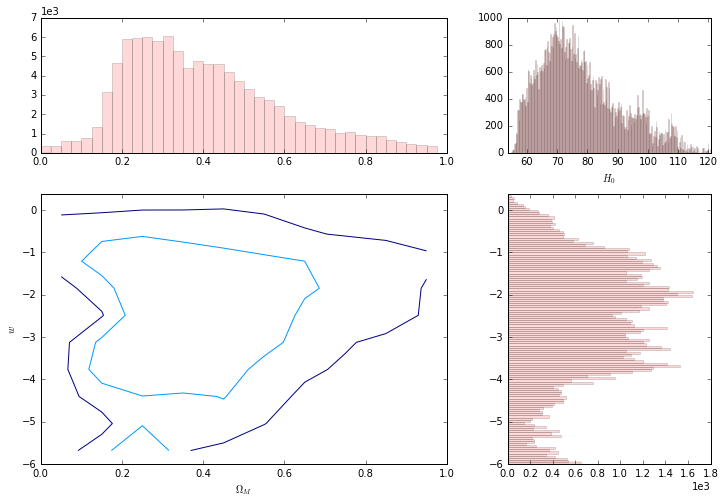

In [148]:
plot_contour_hist_1(fd2,loglike='am_fithyper')
plot_contour_hist_1(fd3,loglike='am_fithyper')
plot_contour_hist_1(fd4,loglike='am_fithyper')
plot_contour_hist_1(fd5,loglike='am_fithyper')

(array([  5371.,   9868.,  13847.,  14749.,  13672.,  13373.,  10609.,
          7514.,   7175.,   3822.]),
 array([  4.87085550e-05,   1.00043074e-01,   2.00037440e-01,
          3.00031805e-01,   4.00026171e-01,   5.00020536e-01,
          6.00014901e-01,   7.00009267e-01,   8.00003632e-01,
          8.99997998e-01,   9.99992363e-01]),
 <a list of 10 Patch objects>)

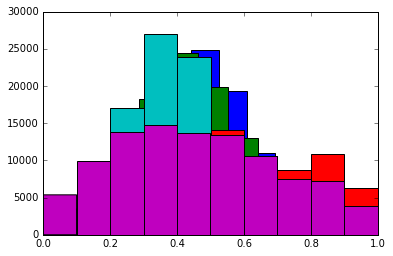

In [73]:
plt.hist(fd1.fithyper_zb)
plt.hist(fd2.fithyper_zb)
plt.hist(fd3.fithyper_zb)
plt.hist(fd4.fithyper_zb)
plt.hist(fd5.fithyper_zb)


(array([   778.,   3905.,   4390.,   3047.,   5673.,   9183.,  14305.,
         18206.,  20002.,  20511.]),
 array([ 0.10745387,  0.19670813,  0.28596239,  0.37521666,  0.46447092,
         0.55372518,  0.64297944,  0.73223371,  0.82148797,  0.91074223,
         0.99999649]),
 <a list of 10 Patch objects>)

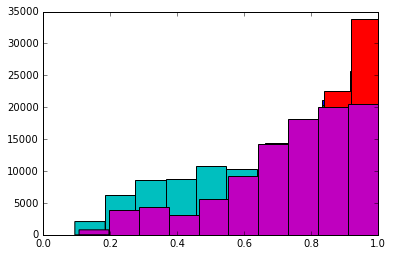

In [74]:
plt.hist(fd1.fithyper_sp)
plt.hist(fd2.fithyper_sp)
plt.hist(fd3.fithyper_sp)
plt.hist(fd4.fithyper_sp)
plt.hist(fd5.fithyper_sp)

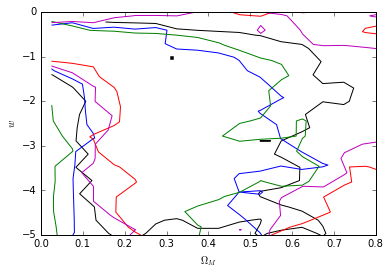

In [75]:
datas={'0':fd1,'1':fd2,'2':fd3,'3':fd4,'4':fd5}
nb=20
cor=['k','b','r','g','m']
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].fithyper_o_m,datas[str(i)].fithyper_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains_fithyper.png')
plt.show()

## Numerical marginalization, no hyperparameters 

Use the likelihood:
\begin{equation}
\log L_i=-\frac{1}{2} \left(\frac{(z_{\rm Obs,i}-z_i)^2}{\sigma_z^2}+\frac{(\mu_{\rm Obs,i}-\mu(z_i,\Omega_m,H_0,w))^2}{\sigma_{\mu}^2} + \frac{(z_i-\bar z)^2}{\sigma_p^2} \right) + constants
\end{equation}

And we fit for $\vartheta=\Omega_m,H_0,w,z_i$. We will do the fit stepwise. First for the cosmological parameters and then for each z individually. 


In [105]:
def log_like_nummarg_cosmpar(data,om,H0,w,zs):
    mu_t=mu(zs,om,H0,w)
    return -0.5*((data.mu_o-mu_t)/data.sig_mu)**2

def log_like_nummarg(data,om,H0,w,zs):
    mu_t=mu(zs,om,H0,w)
    return -0.5*(((data.z-zs)/(data.sig_z))**2+((data.mu_o-mu_t)/data.sig_mu)**2+\
                 ((zs-data.zb)/data.sp)**2)

def MCMC_SNe_nmarg(N,data):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)    
    nzs=len(data.z)
    zs=np.zeros((N,nzs))
    log_like=np.zeros((N,2))
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    zs[0,:]=data.z+np.random.randn(nzs)*0.05
    log_like[0,0]=sum(log_like_nummarg(data,o_m[0],H0[0],w[0],zs[0,:]))
    log_like[0,-1]=sum(log_like_nummarg(data,o_m[0],H0[0],w[0],zs[0,:]))
    #
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        zs[i+1,:]=zs[i,:]+np.random.randn(nzs)*0.01
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1,0]=log_like[i,-1]
        else:
            log_like[i+1,0]=sum(log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i,:]))
            r=sp.exp(log_like[i+1,0]-log_like[i,-1])
            teste=np.random.rand()
            
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1,0]=log_like[i,-1]
         
        log_like_old=log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i,:])
        log_like_new=log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:])
        r=sp.exp(log_like_new-log_like_old)
        teste=np.random.rand(nzs)
        for j in range(nzs):
            if r[j]<teste[j]:
                zs[i+1,j]=zs[i,j]
        
        log_like[i+1,-1]=sum(log_like_nummarg(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:]))
        
        if i%1000==0:
            inc100 = np.int64(i/(N)*100)
            inc50 = np.int64(i/(N)*50)
            sys.stdout.write('\r')
            sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
            sys.stdout.flush()
    
    data.nmarg_o_m=o_m
    data.nmarg_w=w
    data.nmarg_H0=H0
    data.nmarg_zs=zs
    data.nmarg_log_like=log_like
    

In [112]:
MCMC_SNe_nmarg(Nsteps,fd1)

[################################################# ]99%

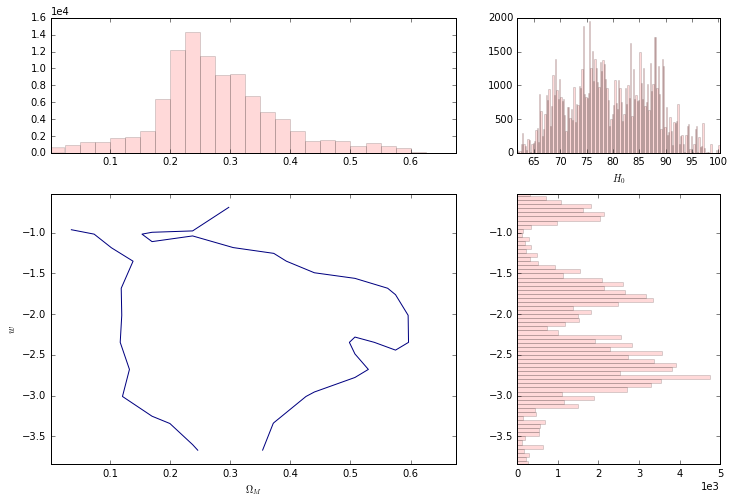

In [113]:
plot_contour_hist_1(fd1,loglike='num_marg')

In [122]:
MCMC_SNe_nmarg(Nsteps,fd2)
MCMC_SNe_nmarg(Nsteps,fd3)
MCMC_SNe_nmarg(Nsteps,fd4)
MCMC_SNe_nmarg(Nsteps,fd5)

[################################################# ]99%

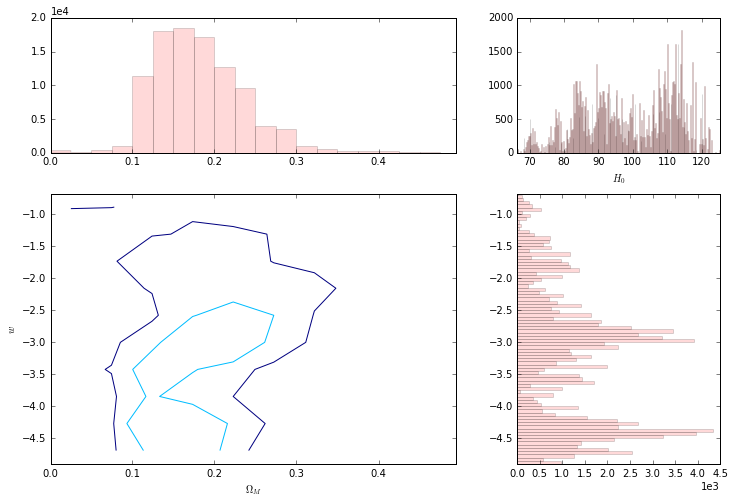

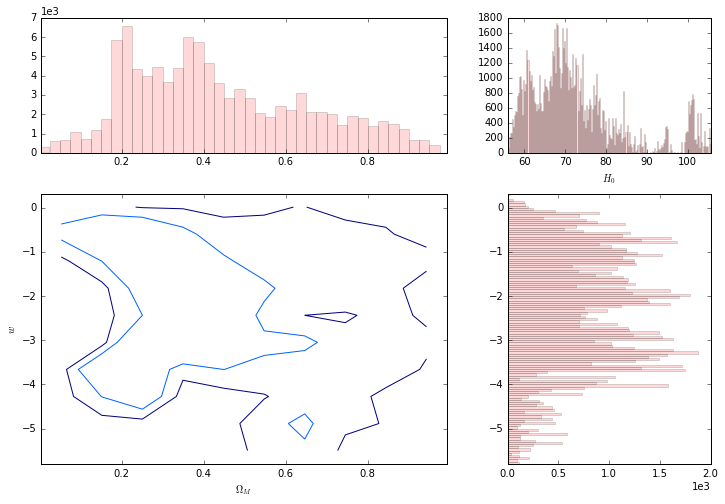

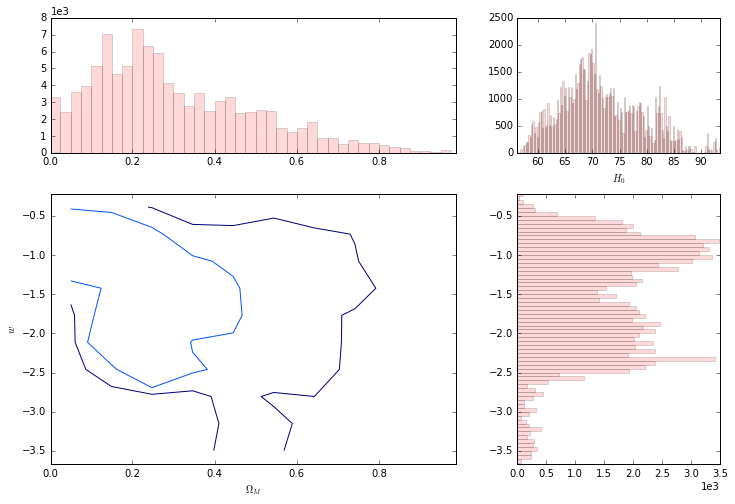

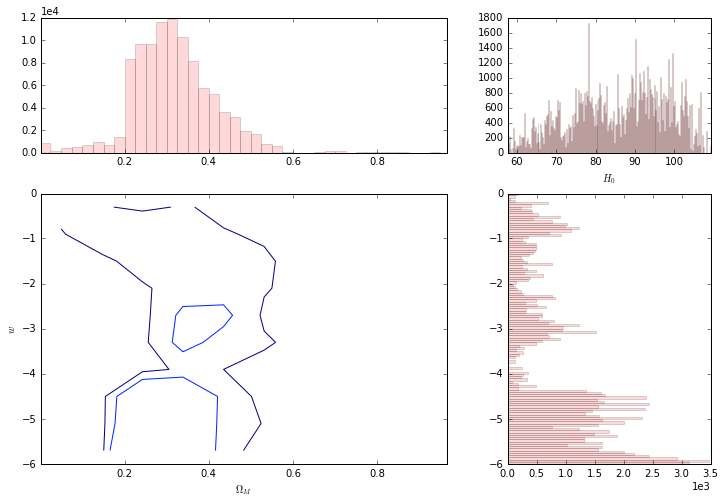

In [147]:
plot_contour_hist_1(fd2,loglike='num_marg')
plot_contour_hist_1(fd3,loglike='num_marg')
plot_contour_hist_1(fd4,loglike='num_marg')
plot_contour_hist_1(fd5,loglike='num_marg')

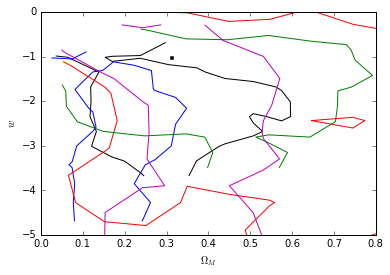

In [125]:
datas={'0':fd1,'1':fd2,'2':fd3,'3':fd4,'4':fd5}
nb=10
cor=['k','b','r','g','m']
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].nmarg_o_m,datas[str(i)].nmarg_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains_nummarg_fixhyper.png')
plt.show()

## Numerical marginalization, fit hyperparameters 

Use the likelihood:
\begin{equation}
\log L_i=-\frac{1}{2} \left(\frac{(z_{\rm Obs,i}-z_i)^2}{\sigma_z^2}+\frac{(\mu_{\rm Obs,i}-\mu(z_i,\Omega_m,H_0,w))^2}{\sigma_{\mu}^2} + \frac{(z_i-\bar z)^2}{\sigma_p^2} \right) + constants
\end{equation}

And we fit for $\vartheta=\Omega_m,H_0,w,z_i,\bar z, \sigma_p$. We will do the fit stepwise. First for the cosmological parameters, then for each z individually and then hyper parameters. 



In [136]:
def log_like_nummarg_fithyper(data,om,H0,w,zs,zb,sp):
    mu_t=mu(zs,om,H0,w)
    return -0.5*(((data.z-zs)/(data.sig_z))**2+((data.mu_o-mu_t)/data.sig_mu)**2+\
                 ((zs-zb)/sp)**2)

def MCMC_SNe_nmarg_fithyper(N,data):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)    
    nzs=len(data.z)
    zs=np.zeros((N,nzs))
    log_like=np.zeros((N,2))
    zb=np.zeros(N)
    sp=np.zeros(N)
    
    #set starting point
    o_m[0]=0.3
    w[0]=-0.9
    H0[0]=70
    zs[0,:]=data.z+np.random.randn(nzs)*0.05
    zb[0]=0.4
    sp[0]=0.2
    log_like[0,:]=sum(log_like_nummarg_fithyper(data,o_m[0],H0[0],w[0],zs[0,:],zb[0],sp[0]))
    
    for i in range(N-1):
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.07
        w[i+1]=w[i]+np.random.randn()*0.07
        H0[i+1]=H0[i]+np.random.randn()*1.3
        zs[i+1,:]=zs[i,:]+np.random.randn(nzs)*0.01
        zb[i+1]=zb[i]+np.random.randn()*0.01
        sp[i+1]=sp[i]+np.random.randn()*0.01
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1,0]=log_like[i,-1]
        else:
            log_like[i+1,0]=sum(log_like_nummarg_fithyper(data,o_m[i+1],H0[i+1],w[i+1],zs[i,:],zb[i],sp[i]))
            r=np.exp(log_like[i+1,0]-log_like[i,-1])
            teste=np.random.rand()
            
            #if r lower than teste then don't accept
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1,0]=log_like[i,-1]
         
        log_like_old=log_like_nummarg_fithyper(data,o_m[i+1],H0[i+1],w[i+1],zs[i,:],zb[i],sp[i])
        log_like_new=log_like_nummarg_fithyper(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:],zb[i],sp[i])
        r=np.exp(log_like_new-log_like_old)
        teste=np.random.rand(nzs)
        for j in range(nzs):
            if r[j]<teste[j]:
                zs[i+1,j]=zs[i,j]
                log_like_new[j]=log_like_old[j]
    
        
        if prior_zb(zb[i+1])==0 or prior_sp(sp[i+1])==0:
            zb[i+1]=zb[i]
            sp[i+1]=sp[i]
            log_like[i+1,-1]=sum(log_like_new)
            continue
        else:
            #compute new log_like
            log_like[i+1,-1]=sum(log_like_nummarg_fithyper(data,o_m[i+1],H0[i+1],w[i+1],zs[i+1,:],zb[i+1],sp[i+1]))
            log_like_old_zbsp=sum(log_like_new)
            #if priors not flat they need to be included after the exp. for now flat prior
            r=np.exp(log_like[i+1,-1]-log_like_old_zbsp)
            #accept or not
            teste=np.random.rand()
            #if r lower than teste then don't accept
            if r<teste:
                zb[i+1]=zb[i]
                sp[i+1]=sp[i]
                log_like[i+1,-1]=log_like_old_zbsp
        
        if i%1000==0:
            inc100 = np.int64(i/(N)*100)
            inc50 = np.int64(i/(N)*50)
            sys.stdout.write('\r')
            sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
            sys.stdout.flush()
    
    data.nmarg_fithyper_o_m=o_m
    data.nmarg_fithyper_w=w
    data.nmarg_fithyper_H0=H0
    data.nmarg_fithyper_zs=zs
    data.nmarg_fithyper_zb=zb
    data.nmarg_fithyper_sp=sp
    data.nmarg_fithyper_log_like=log_like
    

In [143]:
MCMC_SNe_nmarg_fithyper(500000,fd1)

[################################################# ]99%

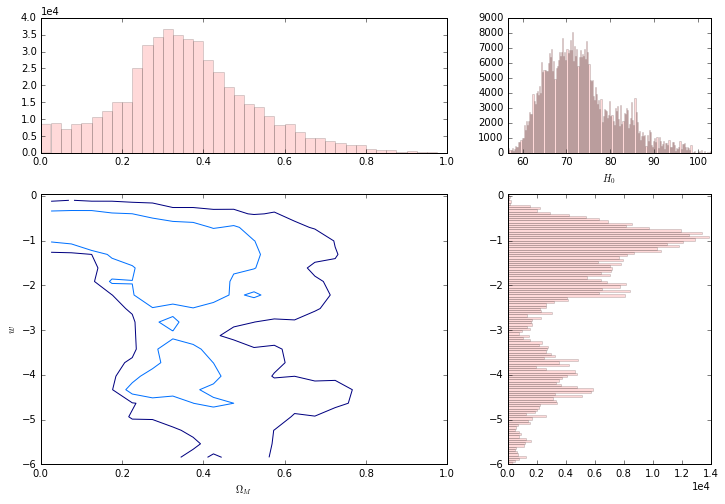

In [146]:
plot_contour_hist_1(fd1,nb=20,loglike='num_marg_fithyper')

In [150]:
MCMC_SNe_nmarg_fithyper(500000,fd2)
MCMC_SNe_nmarg_fithyper(500000,fd3)
MCMC_SNe_nmarg_fithyper(500000,fd4)
MCMC_SNe_nmarg_fithyper(500000,fd5)

[                                                  ]0%

/Users/Ze/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:53: RuntimeWarning: overflow encountered in exp


[################################################# ]99%

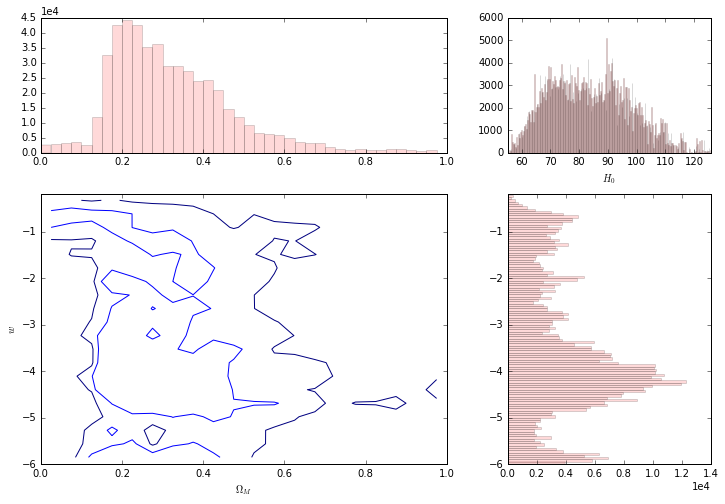

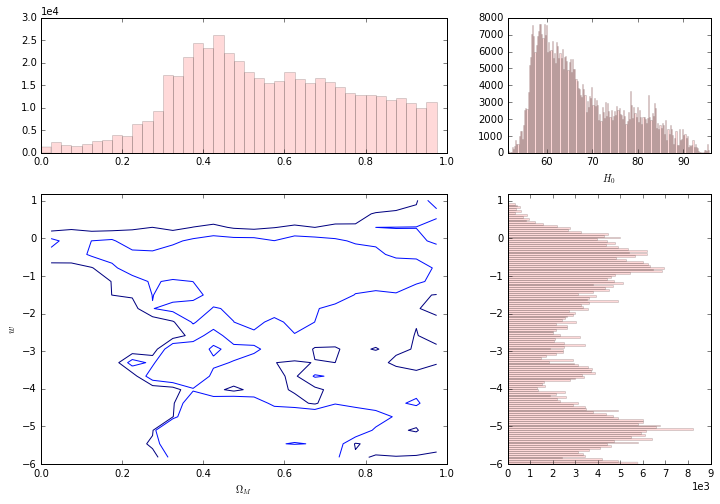

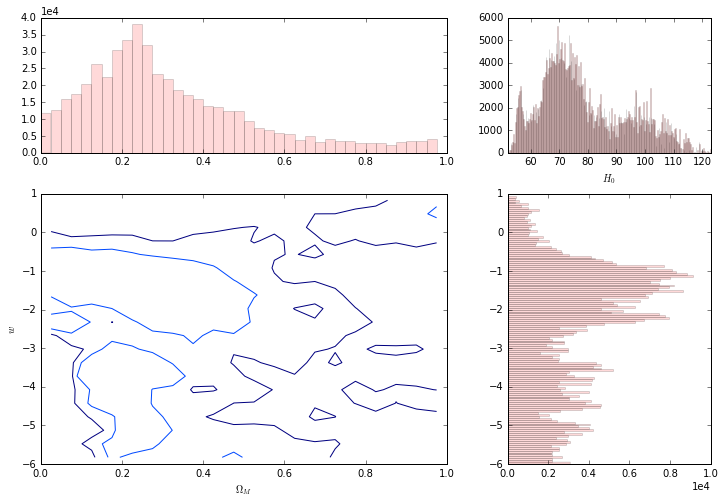

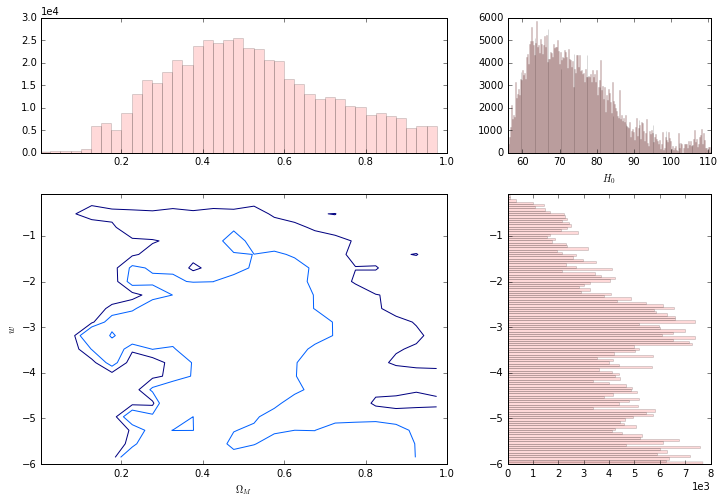

In [151]:
plot_contour_hist_1(fd2,nb=20,loglike='num_marg_fithyper')
plot_contour_hist_1(fd3,nb=20,loglike='num_marg_fithyper')
plot_contour_hist_1(fd4,nb=20,loglike='num_marg_fithyper')
plot_contour_hist_1(fd5,nb=20,loglike='num_marg_fithyper')

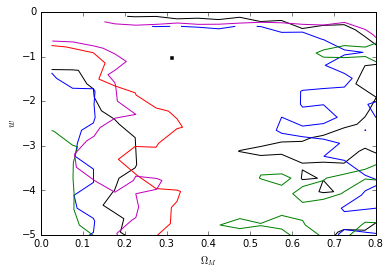

In [155]:
datas={'0':fd1,'1':fd2,'2':fd3,'3':fd4,'4':fd5}
nb=20
cor=['k','b','r','g','m']
for i in range(5):
    Hist_mcmc, omedges,wedges = np.histogram2d(datas[str(i)].nmarg_fithyper_o_m,datas[str(i)].nmarg_fithyper_w,bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Nsteps)
    #plt.plot(om_max,w_max,'rx',ms=10)
    plt.contour(om_c,w_c, Hist_mcmc.T,levels=[N95,Nmax],colors=cor[i])
plt.plot(0.31,-1,'sk',ms=3)    
    
plt.xlim([0,0.8])
plt.ylim([-5,0])
plt.ylabel(r'$w$')
plt.xlabel(r'$\Omega_M$')

plt.savefig('../general_datasets/5cosmo_chains_nummarg_fithyper.png')
plt.show()